In [0]:
from pyspark.sql.functions import col
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import functions as f
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, IntegerType, NullType, ShortType, DateType, BooleanType, BinaryType
from pyspark.sql.types import FloatType
from pyspark.sql import SQLContext
from pyspark.sql.functions import when
import matplotlib.pyplot as plt
import numpy as np
from pyspark.sql.functions import col
from pyspark.sql import types
from pyspark.sql.functions import count
import numpy as np
import pandas as pd
import os
import time
from pytz import timezone 
from datetime import  datetime, timedelta 
from delta.tables import DeltaTable
import datetime as dt
import pytz

from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler

from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler, OneHotEncoder 
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.classification import LogisticRegression
from pyspark.mllib.evaluation import MulticlassMetrics
from sklearn.metrics import classification_report
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

%matplotlib inline
sqlContext = SQLContext(sc)

In [0]:
#Load dataset
all_flight_weather = spark.read.parquet("/mnt/v2team11/full_joined_flight_weather_graph_delay_features_v2/")

### Split training, validation and test datasets

In [0]:
# split by year
all_flight_weather.createOrReplaceTempView("all")
flights_train = spark.sql("SELECT * FROM all WHERE YEAR in (2015, 2016, 2017)")
flights_validation = spark.sql("SELECT * FROM all WHERE YEAR = 2018")
flights_test = spark.sql("SELECT * FROM all WHERE YEAR = 2019")

print("Training Data Set Count: " + str(flights_train.count()))
print("Validation Data Set Count: " + str(flights_validation.count()))
print("Test Data Set Count: " + str(flights_test.count()))

In [0]:
# Save train, test, and evaluation files

flights_train.write.mode("overwrite").parquet(f"/mnt/v2team11/flights_train")
flights_validation.write.mode("overwrite").parquet(f"/mnt/v2team11/flights_validation")
flights_test.write.mode("overwrite").parquet(f"/mnt/v2team11/flights_test")

In [0]:
#Read in the Train and Test Data. 
train = spark.read.parquet(f"/mnt/v2team11/flights_train")
validation = spark.read.parquet(f"/mnt/v2team11/flights_validation")
test = spark.read.parquet(f"/mnt/v2team11/flights_test")


# Model Feature Pipeline

Airline:
Carrier, departure airport, arrival airport, distance, scheduled departure time, scheduled arrival time, time of day, day of week

Weather:
Elevation, wind direction, wind speed, ceiling height, visibility distance, air temperature, dew point temperature, sea level pressure, liquid precipitation

### Encoding Features

In [0]:
#Specify Categorical Variables to be string indexed and encoded
### Used Distance_group instead of distance
### scheduled departure time&scheduled arrival time >> need some feature engineering?
cat_var = ["OP_UNIQUE_CARRIER","ORIGIN","DEST","DAY_OF_WEEK","DISTANCE_GROUP", "DAY_OF_MONTH", "MONTH", "DEP_DEL15_PREV_FIN"]
           
#Empty vector to store pipeline
stages = []

#Use the OneHotEncoderEstimator to convert categorical features into one-hot vectors
#Loop through the specified categorical variables 
for CatVar in cat_var:
  #Encoding
  stringIndexer = StringIndexer(inputCol = CatVar, outputCol = CatVar+'_Index', handleInvalid='skip')
  
  #Rename (Column Name + "ClassVec")
  encoder = OneHotEncoder(inputCols = [stringIndexer.getOutputCol()],outputCols = [CatVar + "classVec"], handleInvalid='error')
  
  #Temp staging the encoder
  stages +=[stringIndexer, encoder]

#Label outcome variable "DEP_DEL15" as "label" 
label_index = StringIndexer(inputCol = 'DEP_DEL15', outputCol = 'label', handleInvalid='skip')

#Stage the labeling var (Dep_Delay15)
stages +=[label_index]

#Numerical variables in interest
num_var = [ 'CRS_DEP_TIME', 'CRS_ARR_TIME', "ORIG_ELEVATION", "DEST_ELEVATION","ORIG_speed", "ORIG_ceiling_height", "DEST_ceiling_height", "ORIG_vis_distance", "DEST_vis_distance", "ORIG_air_temp", \
           "DEST_air_temp", "ORIG_dew_point", "DEST_dew_point", "ORIG_sea_level_pressure", "DEST_sea_level_pressure", "CRS_DEP_TIME", "CRS_ARR_TIME", "ORIG_precipitation_hrs", \
           "ORIG_precipitation_depth", "DEST_precipitation_hrs", "DEST_precipitation_depth", "NUM_PREV_DELAYS_ORIGIN"]
           
#Use vector assembler with only the features of interest (categorical and numerical)
assemblerInputs = [c+'classVec' for c in cat_var] + num_var

#Pass it through the vector assembler to get the feature vector
assembler = VectorAssembler(inputCols = assemblerInputs, outputCol = 'features', handleInvalid = 'skip')

#Append the process into the stages array to reproduce
stages += [assembler]


### Encoding pipeline for training

In [0]:
#Create a ML Pipeline Object and pass the stages vector
pipeline = Pipeline(stages = stages)

#Fit the pipeline onto the dataset
PipelineModel = pipeline.fit(train)
train = PipelineModel.transform(train)

#Only select the features of interest to pass into the model
selectedCols =  ['label','features'] + assemblerInputs
train = train.select(selectedCols)

#Getting rid of label == 2
train = train.where("label != 2") 

#Print the schema to check
train.printSchema()

root
-- label: double (nullable = false)
-- features: vector (nullable = true)
-- OP_UNIQUE_CARRIERclassVec: vector (nullable = true)
-- ORIGINclassVec: vector (nullable = true)
-- DESTclassVec: vector (nullable = true)
-- DAY_OF_WEEKclassVec: vector (nullable = true)
-- DISTANCE_GROUPclassVec: vector (nullable = true)
-- DAY_OF_MONTHclassVec: vector (nullable = true)
-- MONTHclassVec: vector (nullable = true)
-- DEP_DEL15_PREV_FINclassVec: vector (nullable = true)
-- CRS_DEP_TIME: integer (nullable = true)
-- CRS_ARR_TIME: integer (nullable = true)
-- ORIG_ELEVATION: double (nullable = true)
-- DEST_ELEVATION: double (nullable = true)
-- ORIG_speed: integer (nullable = true)
-- ORIG_ceiling_height: integer (nullable = true)
-- DEST_ceiling_height: integer (nullable = true)
-- ORIG_vis_distance: integer (nullable = true)
-- DEST_vis_distance: integer (nullable = true)
-- ORIG_air_temp: integer (nullable = true)
-- DEST_air_temp: integer (nullable = true)
-- ORIG_dew_point: integer (nullable = true)
-- DEST_dew_point: integer (nullable = true)
-- ORIG_sea_level_pressure: integer (nullable = true)
-- DEST_sea_level_pressure: integer (nullable = true)
-- CRS_DEP_TIME: integer (nullable = true)
-- CRS_ARR_TIME: integer (nullable = true)
-- ORIG_precipitation_hrs: integer (nullable = true)
-- ORIG_precipitation_depth: integer (nullable = true)
-- DEST_precipitation_hrs: integer (nullable = true)
-- DEST_precipitation_depth: integer (nullable = true)
-- NUM_PREV_DELAYS_ORIGIN: long (nullable = true)

### Model imbalance
From the above model performance metrics, we can see we got a low recall and f-1 score. This is because we have a lot of false negatives meaning that when the model predicts the flight is not delayed but it’s actually delayed. This primarily due to the imbalance in the dataset where only 18% of flights is delayed.

To account for the imbalance, we tried two options for the baseline model including: 
1. class weight option where a weight column that utilizes a balancing ratio; 
2. adjusting the threshold for the model (increase sample size for minority class and decrease sample size to majority class) to resemble the actual mix of delays to no delays in real data. 

The second option provides more improvement to the results, so we decided to use threshold method shown below：

In [0]:
## Deal with imbalance in the data

#Train data where label == 0
df_class_0 = train.where("label == 0")
count_class_0 = train.where("label == 0").count()
print(count_class_0)

#Train data where label == 1
df_class_1 =  train.where("label == 1")
count_class_1 = train.where("label == 1").count()
print(count_class_1)

#OverSampling by 40% for "lable == 1"
df_class_1_over = df_class_1.sample(True, 1.4, seed = None) 

#UnderSampling by 40% for "lable == 0"
df_class_0_under = df_class_0.sample(False, 0.4, seed = None)

#Join the two  sampled sets together
train = df_class_1_over.union(df_class_0_under)

#Print the distribution post rebalancing
display(train.groupby("label").count())

7852517
1796885

label,count
1.0,2517259
0.0,3141421


### Create a function of model performance metrics

In [0]:
## Create a function of evaluation metrics for model predictions
def evaluation_metrics(predictions, model_name):
  predictions = predictions.createOrReplaceTempView('predictions')
  display(predictions)
  true_positives = spark.sql("SELECT COUNT(*) FROM predictions WHERE predictions.label = 1 AND predictions.prediction = 1").collect()[0][0]
  true_negatives = spark.sql("SELECT COUNT(*) FROM predictions WHERE predictions.label = 0 AND predictions.prediction = 0").collect()[0][0]
  false_positives = spark.sql("SELECT COUNT(*) FROM predictions WHERE predictions.label = 0 AND predictions.prediction = 1").collect()[0][0]
  false_negatives = spark.sql("SELECT COUNT(*) FROM predictions WHERE predictions.label = 1 AND predictions.prediction = 0").collect()[0][0]
  
  # Now we should compute our main statistics
  accuracy = (true_positives + true_negatives)/(true_positives + true_negatives + false_positives + false_negatives)
  recall = (true_positives) / (true_positives + false_negatives)
  precision = (true_positives) / (true_positives + false_positives) if (true_positives + false_positives) != 0 else 0
  f1_score = (2 * recall * precision) / (recall + precision) if (recall + precision) != 0 else 0

  print("The accuracy is: %s" % np.round(accuracy, 4))
  print("The recall is: %s" % np.round(recall, 4))
  print("The precision is: %s" % np.round(precision, 4))
  print("The f1_score is: %s" % np.round(f1_score, 4))
  df_cols = ['Model','accuracy', 'precision', 'recall', 'f1_score', 'true_positives', 'true_negatives', 'false_positives', 'false_negatives']
  metrics_dataframe = pd.DataFrame(columns = df_cols)
  result_dict = {'Model': model_name,
                 'accuracy': accuracy,
                 'precision': precision, 
                 'recall': recall, 
                 'f1_score': f1_score, 
                 'true_positives': true_positives, 
                 'true_negatives': true_negatives, 
                 'false_positives': false_positives, 
                 'false_negatives': false_negatives}
  metrics_dataframe = metrics_dataframe.append(result_dict, ignore_index=True)
  
  return metrics_dataframe

def confusion_matrix(model_results,index):
  confusion_matrix = pd.DataFrame(columns = ['_','Predicted Delay', 'Predicted No Delay'])
  conf_matrix_delay = {'_': 'Actual Delay', 'Predicted Delay': model_results['true_positives'][index], 'Predicted No Delay': model_results['false_negatives'][index] }
  conf_matrix_no_delay = {'_': 'Actual  No Delay', 'Predicted Delay': model_results['false_positives'][index], 'Predicted No Delay': model_results['true_negatives'][index] }
  confusion_matrix = confusion_matrix.append(conf_matrix_delay,ignore_index=True)
  confusion_matrix = confusion_matrix.append(conf_matrix_no_delay,ignore_index=True)
  return confusion_matrix

def AUC(model, predictions):
  from pyspark.ml.evaluation import BinaryClassificationEvaluator
  import matplotlib.pyplot as plt
  evaluator = BinaryClassificationEvaluator()
  evaluation = evaluator.evaluate(predictions)
  print("evaluation (area under ROC): %f" % evaluation)

def ROC(model, predictions):
  plt.figure(figsize=(10,10))
  plt.plot([0, 1], [0, 1], 'r--')
  plt.plot(model.summary.roc.select('FPR').collect(),
         model.summary.roc.select('TPR').collect())
  plt.xlabel('FPR')
  plt.ylabel('TPR')
  plt.show()

def showPR(model_results):
  pr = model_results.toPandas()
  ax.plot(pr['recall'], pr['precision'])
  ax.set_xlabel('Precision')
  ax.set_ylabel('Recall')
  ax.set_title('Precision Recall')

### Model 2 - Random Foreset

In [0]:
# train a model on our transformed train data
startTime = time.time()
rf = RandomForestClassifier(labelCol = "label", featuresCol = "features", numTrees = 15, featureSubsetStrategy = "auto", impurity = "gini", subsamplingRate = 0.6, maxDepth = 15, maxBins = 15)
model = rf.fit(train)
train_preds = model.transform(train)
endTime = time.time()
print(f"The training time of the Random Forest model is: {(endTime - startTime) / (60)} minutes")

The training time of the Random Forest model is: 13.514055240154267 minutes

In [0]:
#evaluate on training data
train_metrics = evaluation_metrics(train_preds, "Random Forest on training data")
display(train_metrics)

The accuracy is: 0.7165
The recall is: 0.4869
The precision is: 0.7968
The f1_score is: 0.6045

Model,accuracy,precision,recall,f1_score,true_positives,true_negatives,false_positives,false_negatives
Random Forest on training data,0.7165393696056324,0.7968449943897432,0.48693837225331205,0.6044857950153286,1225750,2828917,312504,1291509


In [0]:
AUC(model, train_preds)

evaluation (area under ROC): 0.760391

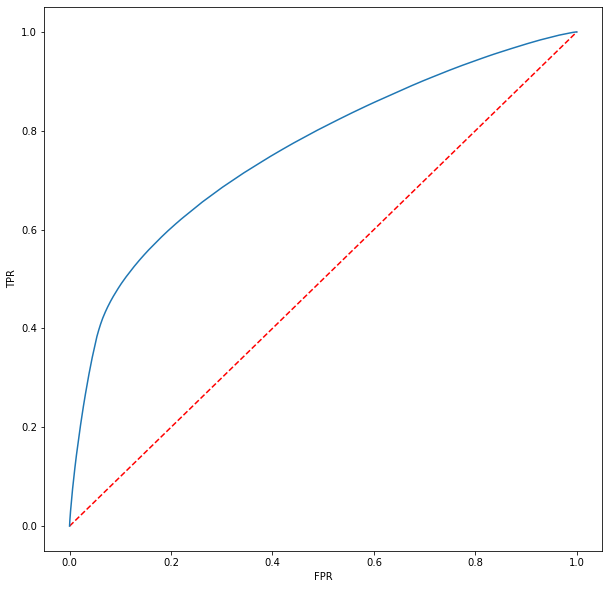

In [0]:
ROC(model, train_preds)

### Evaluate against validation dataset

In [0]:
#Run the fitted model on the transformed validation data
#pipeline = Pipeline(stages = stages)
#PipelineModel = pipeline.fit(validation)
validation = PipelineModel.transform(validation)

#apply the encoding transformations from our pipeline to the validation data
selectedCols =  ['label','features'] + assemblerInputs
validation = validation.select(selectedCols)

#Getting rid of label == 2
validation = validation.where("label != 2") 

#Print the schema to check
validation.printSchema()

root
-- label: double (nullable = false)
-- features: vector (nullable = true)
-- OP_UNIQUE_CARRIERclassVec: vector (nullable = true)
-- ORIGINclassVec: vector (nullable = true)
-- DESTclassVec: vector (nullable = true)
-- DAY_OF_WEEKclassVec: vector (nullable = true)
-- DISTANCE_GROUPclassVec: vector (nullable = true)
-- DAY_OF_MONTHclassVec: vector (nullable = true)
-- MONTHclassVec: vector (nullable = true)
-- DEP_DEL15_PREV_FINclassVec: vector (nullable = true)
-- CRS_DEP_TIME: integer (nullable = true)
-- CRS_ARR_TIME: integer (nullable = true)
-- ORIG_ELEVATION: double (nullable = true)
-- DEST_ELEVATION: double (nullable = true)
-- ORIG_speed: integer (nullable = true)
-- ORIG_ceiling_height: integer (nullable = true)
-- DEST_ceiling_height: integer (nullable = true)
-- ORIG_vis_distance: integer (nullable = true)
-- DEST_vis_distance: integer (nullable = true)
-- ORIG_air_temp: integer (nullable = true)
-- DEST_air_temp: integer (nullable = true)
-- ORIG_dew_point: integer (nullable = true)
-- DEST_dew_point: integer (nullable = true)
-- ORIG_sea_level_pressure: integer (nullable = true)
-- DEST_sea_level_pressure: integer (nullable = true)
-- CRS_DEP_TIME: integer (nullable = true)
-- CRS_ARR_TIME: integer (nullable = true)
-- ORIG_precipitation_hrs: integer (nullable = true)
-- ORIG_precipitation_depth: integer (nullable = true)
-- DEST_precipitation_hrs: integer (nullable = true)
-- DEST_precipitation_depth: integer (nullable = true)
-- NUM_PREV_DELAYS_ORIGIN: long (nullable = true)

In [0]:
# run the fitted model on the transformed validation data
validation_preds = model.transform(validation)

In [0]:
# display our evaluation metrics
validation_metrics = evaluation_metrics(validation_preds, "Random Forest Model on validation data")
display(validation_metrics)

The accuracy is: 0.8136
The recall is: 0.4898
The precision is: 0.5136
The f1_score is: 0.5014

Model,accuracy,precision,recall,f1_score,true_positives,true_negatives,false_positives,false_negatives
Random Forest Model on validation data,0.8135970079404521,0.5135661394860597,0.4897963282540281,0.5013996786274609,317029,2435006,300280,330238


evaluation (area under ROC): 0.752435

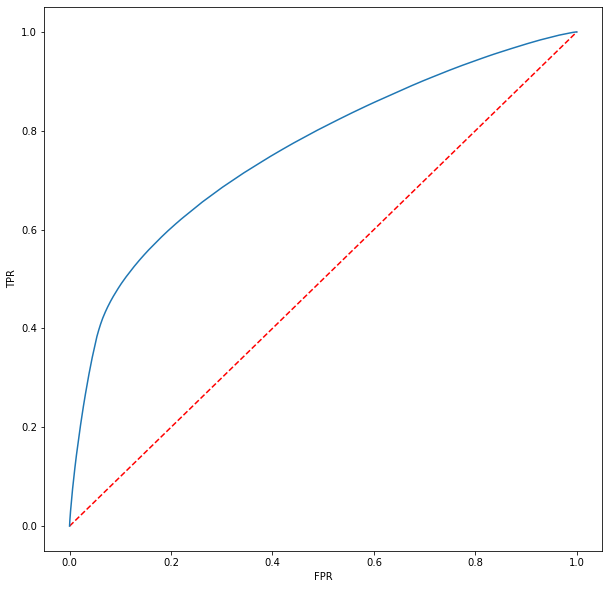

In [0]:
AUC(model, validation_preds)
ROC(model, validation_preds)

In [0]:
##Creat a confusion matrix function
def confusion_matrix(model_preds):
    rdd_preds = model_preds.select(['prediction', 'label']).rdd
    confusion_matrix = MulticlassMetrics(rdd_preds).confusionMatrix().toArray()
    confusion_matrix = pd.DataFrame(confusion_matrix)
    ax = plt.axes()
    sn.heatmap(confusion_matrix, annot=True, cmap= 'Blues', fmt=',', ax=ax)
    size = f'{int(model_preds.count()):,}'
    ax.set_title('Confusion Matrix - N={}'.format(size))
    ax.set_ylabel('Actual Values')
    ax.set_xlabel('Predicted Values')
    plt.show()

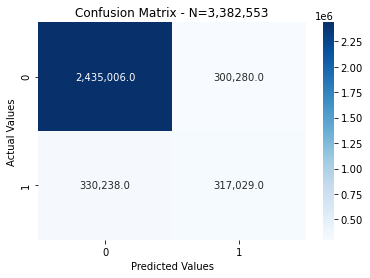

In [0]:
# Confusion matrix
confusion_matrix(validation_preds)